### Say you wanted to extract the most likely stimuli for a single trial. How would you calculate that?

## Python version of Gardner's lab tutorial on a channel response model

- https://gru.stanford.edu/doku.php/tutorials/channel
- https://gru.stanford.edu/doku.php/tutorials/channel_full_code

#### Created by Daniela del Río, https://github.com/DanidelRio

The underlying idea is that every voxel (channel responses) is modeled as the linear sum of underlying populations of neurons (channel responses) tuned to different orientations.

The BOLD response for every stimuli is a weighted sum of the channel responses.
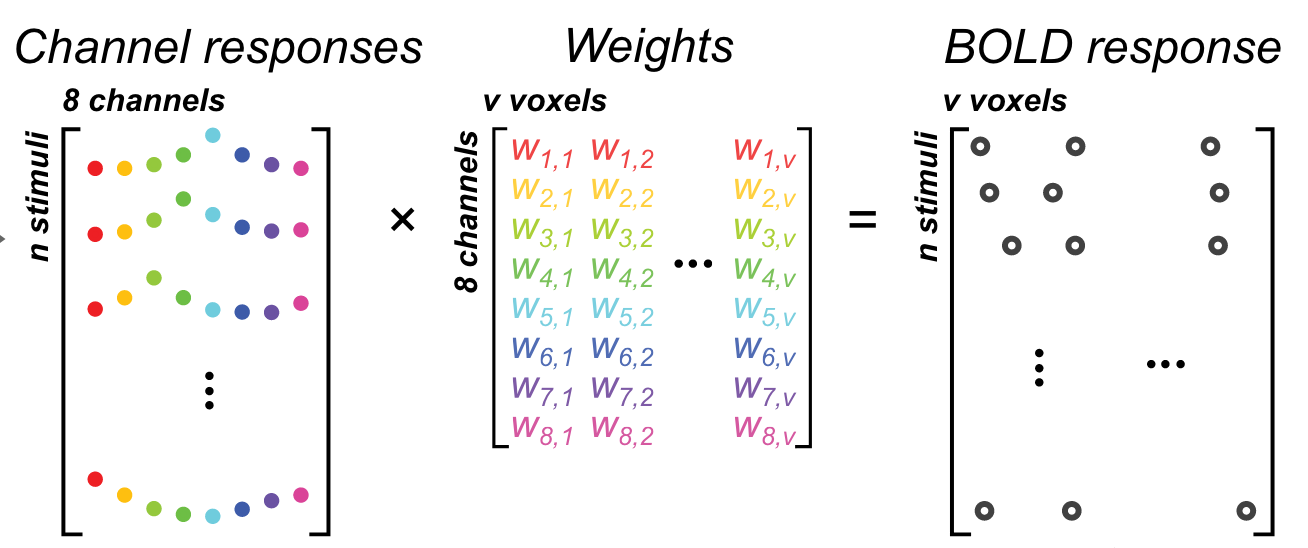

See Gardner and Liu, 2018.

$$C W = B$$

In forward encoding, we know the channel response matrix and the BOLD response matrix. So we solve for the weight matrix. For example, using the least-squares regression.

In inverse encoding, using the BOLD response matrix and an estimated weight matrix, we solve for the channel responses.


### Parts of the channel encoding model tutorial:
1. Simulating data for fitting the model.
    - Obtain channel response (C) and BOLD response (B) matrices.
2. Perform forward encoding.
    - Fitting the weight matrix to the simulated data.
    $$ W = C^\dagger B$$
    
    Question: Why calculate the pseudoinverse of a matrix?
$$C  W = B$$
$$C^\dagger C W = C^\dagger B$$
$$\mathrm(1) W = C^\dagger B$$
$$W = C^\dagger B$$
Note that $C^\dagger$ is the pseudoinverse of C.

3. Computing the goodness-of-fit. $r^2$
4. Inverting the encoding model.
    - Solving for the channel response matrix (C) using the estimated weight matrix (W).
    - Note on cross-validation. Dividing voxel response (B) in 2 parts (train and test voxel response) to test the model's ability to predict new data that was not used in estimating it.
    
    $$C = B W^\dagger$$
5. Use a simplified Bayesian algorithm to determine stimulus likelihood.
    - Stimulus likelihood function is the probability of any stimulus given a particular response. Requirements: mean response and variance around the mean response. This is obtained from the residuals once the encoding model is fitted. For example, fit a multi-variate gaussian noise model to these residuals.
    - Compute the multivariate gaussian probability distribution.
    - Note: The channel responses depend on the basis/kernel we use. In this case, we assumed them to be linear. If we assumed them to be bimodal, that is what we would obtain.

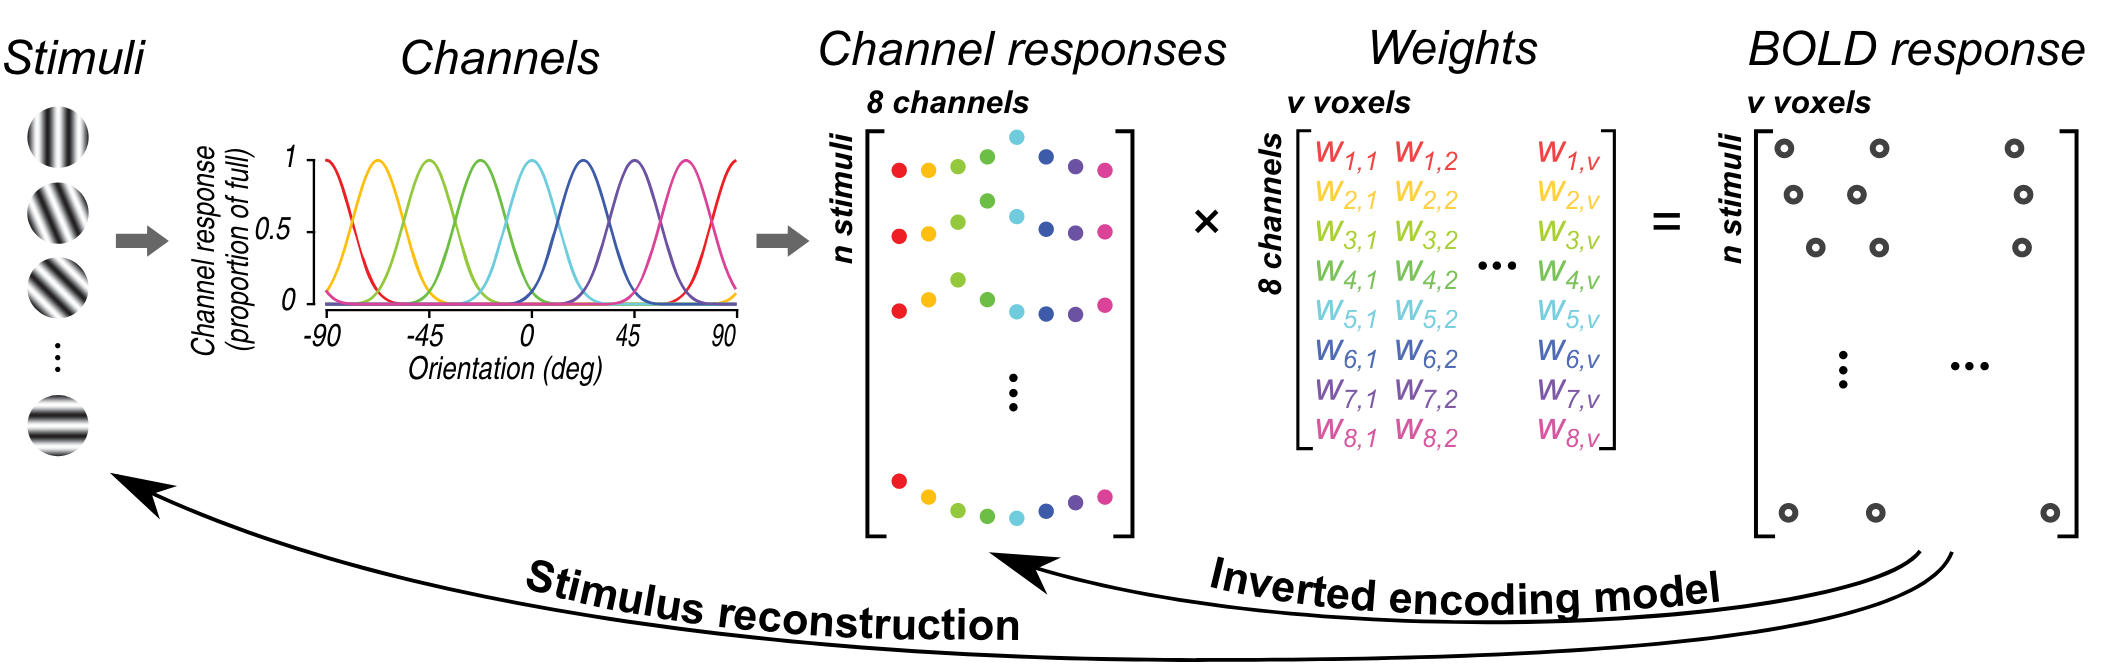
See Gardner and Liu, 2018.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from scipy.stats import multivariate_normal, pearsonr

### Create simulated stimuli, channel responses [C] and BOLD responses [B]

In [2]:
# Function that simulates different orientation stimuli.
def simulated_stimuli(nStimuli = 8, nRepeats = 20):
    # evenly space stimuli
    # 0.,  22.,  45.,  68.,  90., 112., 135., 158
    stimuli_1 = [i*180/nStimuli+1 for i in range(nStimuli)] # HERE! +1 because of the code structure in MAtlab

    stimuli = np.asarray([stimuli_1 for i in range(nRepeats)]).reshape(1,nStimuli*nRepeats) # Dimensions 1 * 160
    
    # Round and make a column array
    stimuli = np.round(stimuli)
    # Converting floats to integers so they can be referenced as indices
    stimuli = stimuli.astype(np.int64)
    # Note python indices start in 0 (unlike Matlab which start at 1)
    # So it is not necessary to add 1.
    
    return stimuli

In [3]:
# Function that simulates BOLD response [B]
def simulate_data(stimuli, nStimuli = 8, nRepeats = 20, nNeurons=90, kappa=10,
                  nVoxels=50, noiseStandardDeviation = 0.5):
    
    neurons = np.arange(0, nNeurons)
    
    orientations = np.arange(0, 180) # 0-180 orientation
    neuralResponse = np.zeros((len(neurons), len(orientations)))

    # Loop over each neuron tuning function
    for iNeuron in range(len(neurons)):

        orientPreference = 2*orientations[iNeuron] # orientation space mapped to 0-360

        # compute the neural response as a Von Mises function
        neuralResponse[iNeuron,:] = np.exp(kappa * np.cos (2*np.pi* (orientations-orientPreference)/180))
        # normalize
        neuralResponse[iNeuron,:] = neuralResponse[iNeuron,:] / np.max(neuralResponse[iNeuron,:])  
    
    # Simulated voxel response
    neuronToVoxelWeights = np.random.rand(nNeurons, nVoxels) # Uniformly distributed random numbers
    # compute the voxelResponse
    nTrials = nStimuli * nRepeats # 160

    # Initialize voxelResponse
    voxelResponse = []

    for iTrial in range(nTrials):
        # get the neural response to this stimulus, by indexing the correct column of the neuralResponse matrix
        thisNeuralResponse = neuralResponse[:,stimuli[0][iTrial]] # 1-D array, 90 elements

        # multiply this by the neuronToVoxelWeights to get the voxel response on this trial.
        # Note that you need to get the matrix dimensions right, so transpose is needed on thisNeuralResponse
        voxelResponse.append(np.matmul(thisNeuralResponse.T, neuronToVoxelWeights))
    # NOTE: In one part of the code, thisNeuralResponse is transposed.
    # Question: What is the right way to think about this?
    # It doesn't matter. This is only creating the simulated BOLD response. It is not calculating anything.
    # For congruence with the Matlab code, I transposed it.
    voxelResponse = np.asarray(voxelResponse)
    
    # Scaling the reponse
    voxelResponse = voxelResponse / np.mean(voxelResponse)

    aux1, aux2 = voxelResponse.shape
    # add gaussian noise
    voxelResponse = voxelResponse + noiseStandardDeviation * np.random.randn(aux1, aux2)

    return orientations, voxelResponse

In [4]:
# make channel basis functions
def create_channel_basis(stimuli, nChannels = 8, exponent = 7):

    orientations = np.arange(0, 180)
    prefOrientation = [i*180/nChannels for i in range(nChannels)]
    # tuned as exponentials and rectified sinusoids to different orientations.

    channelBasis = np.zeros((180, nChannels)) # contains the ideal channel responses to each of 180 orientations
    
    # loop over each channel
    for iChannel in range(nChannels):
        # get sinusoid. Note the 2 here which makes it so that our 0 - 180 orientation
        # space gets mapped to all 360 degrees
        thisChannelBasis =  np.cos(2*np.pi*(orientations-prefOrientation[iChannel])/180)
        # rectify
        thisChannelBasis[thisChannelBasis<0] = 0
        # raise to exponent
        thisChannelBasis = thisChannelBasis**exponent
        # keep in matrix
        channelBasis[:,iChannel] = thisChannelBasis
        
    
    # compute the channelResponse for each trial
    nTrials = nStimuli * nRepeats # 160

    channelResponse = np.zeros((nTrials, nChannels)) # 160*8

    for iTrial in range(nTrials):
        channelResponse[iTrial, :] = channelBasis[stimuli[0][iTrial],:]
        
    return channelBasis, channelResponse

In [5]:
# Inputs: channelResponse, voxelResponse
# Outputs: estimatedWeights, modelPrediction, estimatedChannelResponse, residualResponse, r2

def model_fit_no_folds(channelResponse, voxelResponse):
    
    # W_estimated
    # Computes the (Moore-Penrose) pseudo-inverse of the matrix channelResponse
    estimatedWeights = np.matmul(np.linalg.pinv(channelResponse), voxelResponse)

    # B_predicted
    modelPrediction = np.matmul(channelResponse, estimatedWeights)
    
    # C_estimated
    estimatedChannelResponse = np.matmul(voxelResponse, np.linalg.pinv(estimatedWeights))
    
    # compute residual
    residualResponse = voxelResponse - modelPrediction
    
    # compute r2
    r2 = 1 - np.var(residualResponse) / np.var(voxelResponse)

    return estimatedWeights, modelPrediction, estimatedChannelResponse, residualResponse, r2

In [6]:
# Implementing the inverted encoding model
# Inputs: channelResponse, voxelResponse
# Outputs: estimatedWeights, modelPrediction, estimatedChannelResponse,
#          testVoxelResponse, residualResponse, r2

def model_fit_with_folds(channelResponse, voxelResponse):
    
    nTrials = channelResponse.shape[0]   
    firstHalf = int(nTrials/2)
    secondHalf = nTrials

    # split VoxelResponse [B] into train and test
    trainVoxelResponse = voxelResponse[0:firstHalf, :]
    testVoxelResponse = voxelResponse[firstHalf:secondHalf, :]
    
    # Divides channelResponse [C] into 2
    C1 = channelResponse[0:firstHalf, :]
    C2 = channelResponse[firstHalf:secondHalf, :]
    
    # W_estimated
    # Computes the (Moore-Penrose) pseudo-inverse of the matrix channelResponse
    estimatedWeights = np.matmul(np.linalg.pinv(C1), trainVoxelResponse)
    
    # B_predicted, compute model prediction on test data
    modelPrediction = np.matmul(C2, estimatedWeights)
    # C_estimated, compute channel response from textVoxelResponses
    estimatedChannelResponse = np.matmul(testVoxelResponse, np.linalg.pinv(estimatedWeights))
    
    # compute residual
    residualResponse = testVoxelResponse - modelPrediction
    
    # compute r2
    r2 = 1 - np.var(residualResponse) / np.var(testVoxelResponse)

    return estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2

In [7]:
# Function that fits some model to the noise to obtain the most likely stimulus
def recover_stim_likelihoods(channelBasis, channelResponse, testVoxelResponse,
                             residualResponse, orientation_length, nVoxels,
                             estimatedWeights):
    
    # compute residual variance, note that this is a scalar
    residualVariance = np.var(residualResponse)

    # make this into a covariance matrix in which the diagonal contains the variance for each voxel
    # and off diagonals (in this case all 0) contain covariance between voxels
    modelCovar = np.identity(nVoxels) * residualVariance
    
    # cycle over each trial
    nTestTrials = np.size(testVoxelResponse, 0)
    likelihood = np.zeros([nTestTrials, orientation_length])

    for iTrial in range(nTestTrials):
      # now cycle over all possible orientations

    # HERE: Perhaps the error comes from here on how likelihoods are computed.
    # Either from computing the predictedResponse or from fitting a multivariate gaussian
    # to each trial/
      for iOrientation in range(orientation_length):
        # compute the mean voxel response predicted by the channel encoding model
        predictedResponse = np.matmul(channelBasis[iOrientation], estimatedWeights)
        # now use that mean response and the model covariance to estimate the probability
        # of seeing this orientation given the response on this trial
        
        mvnpdf = multivariate_normal.pdf(testVoxelResponse[iTrial], mean=predictedResponse,
                                         cov = modelCovar)
        likelihood[iTrial,iOrientation] = mvnpdf
        
    return likelihood

In [8]:
# Simulation for visualizing the recurrency plot
nStimuli = 8
nRepeats = 20

nNeurons = 90
kappa = 10
nVoxels = 50
noiseStandardDeviation = 0.05 # This could be 0.05 or 0.5

nChannels = 8 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

stimuli_1 = [i*180/nStimuli+1 for i in range(nStimuli)] # HERE! +1 because of the code structure in MAtlab
stimuli_alt = np.asarray([[stimuli_1[i] for k in range(20)] for i in range(len(stimuli_1))]).reshape(1,nStimuli*nRepeats)
stimuli_alt = np.round(stimuli_alt)
# Converting floats to integers so they can be referenced as indices
stimuli_alt = stimuli_alt.astype(np.int64)

print(stimuli_alt)

orientations, voxelResponse = simulate_data(stimuli_alt, nStimuli, nRepeats, nNeurons,
                                            kappa, nVoxels, noiseStandardDeviation)

# Obtaining the recurrency plot
matrix = np.zeros([160,160])

for i in range(160):
    for j in range(160):
        matrix[i, j] = pearsonr(voxelResponse[i,:], voxelResponse[j,:])[0]

[[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24
   24  24  24  24  46  46  46  46  46  46  46  46  46  46  46  46  46  46
   46  46  46  46  46  46  68  68  68  68  68  68  68  68  68  68  68  68
   68  68  68  68  68  68  68  68  91  91  91  91  91  91  91  91  91  91
   91  91  91  91  91  91  91  91  91  91 114 114 114 114 114 114 114 114
  114 114 114 114 114 114 114 114 114 114 114 114 136 136 136 136 136 136
  136 136 136 136 136 136 136 136 136 136 136 136 136 136 158 158 158 158
  158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158]]


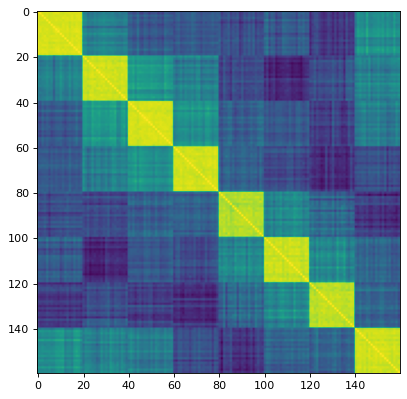

In [9]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(matrix)
plt.show()

In [10]:
# Matlab verification
# # HERE! ADDING NOISE IS DONE IN MATLAB BECAUSE OF THE USE OF A RANDOM VARIABLE


# # However, importing the same values as the ones used in Matlab to compare the code,
# file = open("voxelResponse.txt", "r")
# voxelResponse = []

# for line in file.readlines():
#     entries = line.split(',')
#     entries_float = [float(element_i) for element_i in entries]

#     voxelResponse.append(entries_float)

# file.close()
# voxelResponse = np.asarray(voxelResponse_matlab)

In [11]:
# # Plot the mean estimatedChannelResponse for each stimulus type 
# colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink']
# prefOrientation = [i*180/nChannels for i in range(nChannels)]

# for i in range(nStimuli):
#     vec_supplement = [iteration*nStimuli+i for iteration in range(int(len(estimatedChannelResponse)/nStimuli))] #start=i, step=nStimuli, end=
# #     means = np.mean(estimatedChannelResponse[vec_supplement,:], 0) # Mean across the first dimension
# #     plt.plot(prefOrientation, means, c=colors[i], label="Preferred orientation")

#     plt.plot(orientations, channelBasis[:,i], c=colors[i], marker="^", label="Orientations")
    
# #     likelihood_means = np.mean(likelihood[vec_supplement,:], 0) # Mean across the first dimension
# #     plt.plot(likelihood_means, c = colors[i], marker=".", label = "Stimulus likelihood")
    
# plt.xlabel('Preferred orientation')
# plt.ylabel('Ideal channel response (normalized to 1)')
# plt.title("r2="+str(round(r2, 4)))
# plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5))
# plt.show()

In [12]:
# Running the simulation.
nStimuli = 8
nRepeats = 20

nNeurons = 90
kappa = 10
nVoxels = 50
noiseStandardDeviation = 0.05 # This could be 0.05 or 0.5

nChannels = 8 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

stimuli = simulated_stimuli(nStimuli, nRepeats)

orientations, voxelResponse = simulate_data(stimuli, nStimuli, nRepeats, nNeurons,
                                            kappa, nVoxels, noiseStandardDeviation)

channelBasis, channelResponse = create_channel_basis(stimuli, nChannels, exponent)

# Model fit with no folds
# estimatedWeights, modelPrediction, estimatedChannelResponse, residualResponse, r2 = model_fit_no_folds(channelResponse, voxelResponse)

# Model fit with folds
estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2 = model_fit_with_folds(channelResponse, voxelResponse)

orientation_length = len(orientations)

likelihood = recover_stim_likelihoods(channelBasis, channelResponse, testVoxelResponse,
                             residualResponse, orientation_length, nVoxels, estimatedWeights)

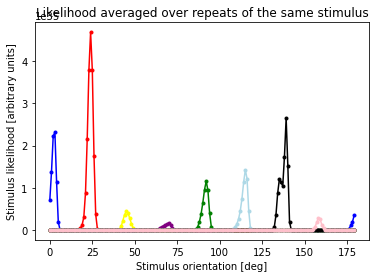

In [13]:
# Now, plotting the likelihood function averaged over repeats
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink']

for i in range(nStimuli):
    vec_supplement = [iteration*nStimuli+i for iteration in range(int(len(estimatedChannelResponse)/nStimuli))] #start=i, step=nStimuli, end=
    means = np.mean(likelihood[vec_supplement,:], 0) # Mean across the first dimension

    plt.plot(means, c = colors[i], marker=".", label = "Stimulus likelihood")

plt.title('Likelihood averaged over repeats of the same stimulus')
plt.xlabel('Stimulus orientation [deg]')
plt.ylabel('Stimulus likelihood [arbitrary units]')
# plt.ylim([0, 1e35])
plt.show()

# What is the most likely stimulus for a given trial?

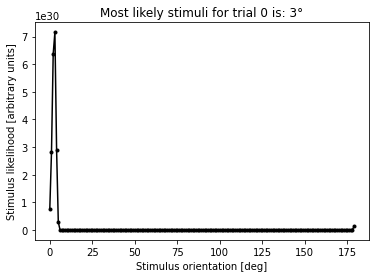

In [14]:
# Single trial
trial_i = 0
likely_stimuli = likelihood[trial_i,:].argmax()

label = "Most likely stimuli for trial " + str(trial_i) + " is: " + str(likely_stimuli)+"°"

plt.plot(likelihood[trial_i,:], marker=".", label = "Stimulus likelihood", c="k")
plt.title(label)
plt.xlabel('Stimulus orientation [deg]')
plt.ylabel('Stimulus likelihood [arbitrary units]')
# plt.ylim([0, 1e35])
plt.show()